# Design Control

In [1]:
img_input_path = '/data2/eranario/data/Borden-Day2Night/train/00000.jpg'
txt_input_path = '/data2/eranario/data/yolo_grl_data/BordenNight/Synthetic/labels/00000.txt'

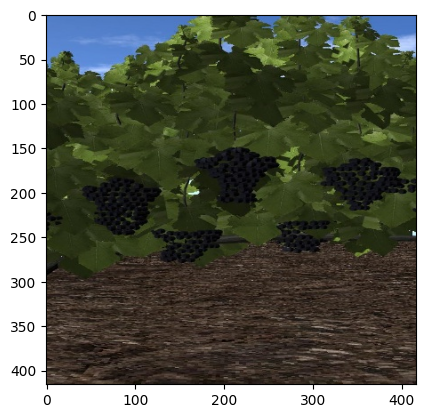

In [2]:
# view image
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread(img_input_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## create canndy edge

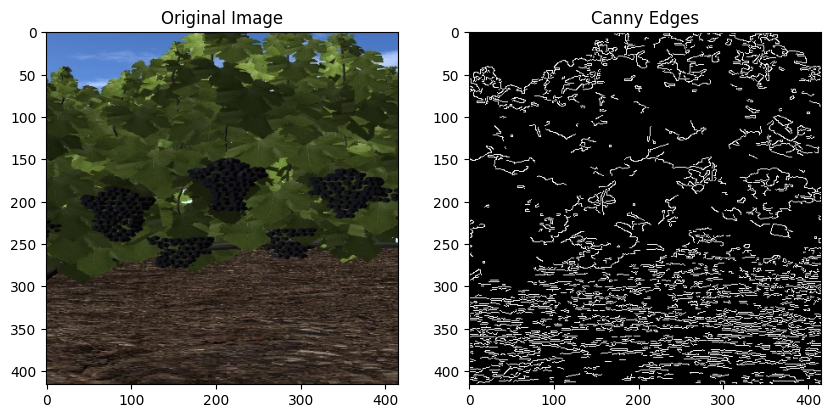

In [3]:
# convert the image to gray scale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply canny edge detection
edges = cv2.Canny(gray_img, threshold1=100, threshold2=200)

# display the original image and the detected edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.show()

# Create Dataset

In [4]:
import os
import torch
import random
from torch.utils.data import Dataset
from PIL import Image

class BordenDataset(Dataset):
    def __init__(self, source_images_path, target_images_path, labels_path, transform=None):
        self.source_images_path = source_images_path
        self.target_images_path = target_images_path
        self.labels_path = labels_path
        self.transform = transform
        
        # Load image file paths
        self.source_image_files = [f for f in os.listdir(source_images_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        self.target_image_files = [f for f in os.listdir(target_images_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        
        # Balance the dataset lengths
        self.balance_dataset_lengths()
        
        # Create dataset structure
        self.data = []
        for source_file, target_file in zip(self.source_image_files, self.target_image_files):
            self.data.append({
                'source': source_file,
                'target': target_file,
                'prompt': ''  # Empty string prompt
            })
    
    def balance_dataset_lengths(self):
        if len(self.source_image_files) < len(self.target_image_files):
            deficit = len(self.target_image_files) - len(self.source_image_files)
            self.source_image_files += random.choices(self.source_image_files, k=deficit)
        elif len(self.target_image_files) < len(self.source_image_files):
            deficit = len(self.source_image_files) - len(self.target_image_files)
            self.target_image_files += random.choices(self.target_image_files, k=deficit)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]

        source_image_file = item['source']
        target_image_file = item['target']
        prompt = item['prompt']

        source_image_path = os.path.join(self.source_images_path, source_image_file)
        target_image_path = os.path.join(self.target_images_path, target_image_file)
        label_path = os.path.join(self.labels_path, source_image_file.replace('jpg', 'txt').replace('jpeg', 'txt').replace('png', 'txt'))
        
        # Load images
        source_image = Image.open(source_image_path).convert("RGB")
        target_image = Image.open(target_image_path).convert("RGB")
        
        # Apply transformations if any
        if self.transform:
            source_image = self.transform(source_image)
            target_image = self.transform(target_image)
        else:
            # Normalize source images to [0, 1]
            source_image = np.array(source_image).astype(np.float32) / 255.0
            
            # Normalize target images to [-1, 1]
            target_image = np.array(target_image).astype(np.float32) / 127.5 - 1.0
        
        # Load label if necessary
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                label = list(map(float, line.strip().split()))
                labels.append(label)
        labels = torch.tensor(labels)

        return dict(jpg=target_image, txt=prompt, hint=source_image)

/home/eranario/miniconda3/envs/diffusers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create SD Model

In [5]:
# !python tool_add_control.py /group/jmearlesgrp/intermediate_data/eranario/AGILE/v2-1_512-ema-pruned.ckpt /group/jmearlesgrp/intermediate_data/eranario/AGILE/v2-1_512-ema-pruned.ckpt/control_sd21_ini.ckpt

# Train Model

In [6]:
import pytorch_lightning as pl
from torchvision import transforms
from torch.utils.data import DataLoader
from ControlNet.tutorial_dataset import MyDataset
from ControlNet.cldm.logger import ImageLogger
from ControlNet.cldm.model import create_model, load_state_dict

# transforms 
class PermuteTransform:
    def __call__(self, x):
        # Permute dimensions from [3, 416, 416] to [416, 3, 416]
        return x.permute(2, 1, 0)
    
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    PermuteTransform(),
])

# Configs
resume_path = '/data2/eranario/intermediate_data/Active-Learning/stable-diffusion-v1-5/control_sd15_ini.ckpt'
batch_size = 1
logger_freq = 300
learning_rate = 1e-5
sd_locked = True
only_mid_control = False
max_epochs = 100

In [8]:
model = create_model('/data2/eranario/scratch/Active-Deep-Learning/experiments/diffusion/ControlNet/models/cldm_v15.yaml').cpu()

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [/data2/eranario/scratch/Active-Deep-Learning/experiments/diffusion/ControlNet/models/cldm_v15.yaml]


In [ ]:
model.load_state_dict(load_state_dict(resume_path, location='cpu'))

In [ ]:
model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control

In [ ]:
dataset = BordenDataset(source_images_path='/data2/eranario/data/Borden-Day2Night/train',
                        target_images_path='/data2/eranario/data/yolo_grl_data/BordenNight/Real/train/images',
                        labels_path='/data2/eranario/data/yolo_grl_data/BordenNight/Synthetic/labels',
                        transform=transform)
dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = ImageLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(max_epochs=max_epochs, 
                     default_root_dir='/data2/eranario/intermediate_data/Active-Learning/stable-diffusion-v1-5/logs/test',
                     precision=32, callbacks=[logger])

In [ ]:
# use lightning=2.1.4 and torch=1.12.1 and lightning=2.1.0 and lightning-utilities=0.11.2
trainer.fit(model, dataloader)

# Run inference

In [ ]:
import ControlNet.config as config

import cv2
import einops
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from ControlNet.annotator.util import resize_image, HWC3
from ControlNet.annotator.canny import CannyDetector
from ControlNet.cldm.model import create_model, load_state_dict
from ControlNet.cldm.ddim_hacked import DDIMSampler


# apply_canny = CannyDetector()

model = create_model('/data2/eranario/scratch/Active-Deep-Learning/experiments/diffusion/ControlNet/models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('/data2/eranario/intermediate_data/Active-Learning/stable-diffusion-v1-5/logs/test/lightning_logs/version_2/checkpoints/epoch=58-step=29028.ckpt', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

In [ ]:
def process(input_image, prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta):
    with torch.no_grad():
        
        # rotate image 270 degrees
        input_image = cv2.rotate(input_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape
        detected_map = HWC3(img)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [255 - detected_map] + results

In [ ]:
def display_images(img):
    """Display a list of images."""
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
img_input_path = '/data2/eranario/data/yolo_grl_data/BordenNight/Synthetic/images/00000.jpg'
output = process(
    input_image=cv2.imread(img_input_path),
    prompt='',
    num_samples=2,
    image_resolution=512,
    ddim_steps=50,
    guess_mode=False,
    strength=2.0,
    scale=0.1,
    seed=0,
    eta=0.0,
)

In [ ]:
display_images(cv2.rotate(output[1], cv2.ROTATE_90_CLOCKWISE))